In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import holidays
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import numpy as np
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from datetime import datetime
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.decomposition import PCA

In [2]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
plt.rcParams['font.family'] = 'DejaVu Sans'  

In [5]:
import holidays

# Vytvoření seznamu svátků pro Česko
cz_holidays = holidays.CountryHoliday('CZ')  # nebo holidays.HolidayBase(country='CZ')


In [4]:
from datetime import date
import holidays

cz_holidays = holidays.CountryHoliday('CZ')

# Zjisti, jestli je 1. leden svátek
print(date(2025, 1, 1) in cz_holidays)        # Výstup: True
print(cz_holidays.get('2025-01-01'))          # Výstup: Den obnovy samostatného českého státu


True
Den obnovy samostatného českého státu


In [4]:
# Načtení dat
data = pd.read_csv("C:\\Users\\ondra\\OneDrive\\Plocha\\DataOdectyDecin20241011.csv")
# Převod timestampu z ns na s, pak na datetime
data['datetime'] = pd.to_datetime(data['v_ts'] // 10**9, unit='s')
data['date'] = data['datetime'].dt.date
data['weekday'] = data['datetime'].dt.weekday  # 0 = pondělí, ..., 6 = neděle

# Státní svátky ČR jako set pro rychlejší hledání
cz_holidays = holidays.CountryHoliday('CZ')
holiday_dates = set(cz_holidays.keys())
holiday_map = dict(cz_holidays)

# Přímá vektorová klasifikace
data['is_holiday'] = data['date'].isin(holiday_dates)
data['is_saturday'] = data['weekday'] == 5
data['is_sunday'] = data['weekday'] == 6
data['is_vacation'] = data['datetime'].dt.month.isin([7, 8])
data['is_workday'] = (~data['is_holiday']) & (~data['is_saturday']) & (~data['is_sunday'])

# Vybrané svátky
target_names = {
    'Den obnovy samostatného českého státu': 'df_novy_rok',
    'Velikonoční pondělí': 'df_velikonocni_pondeli',
    'Den vzniku samostatného československého státu': 'df_den_statnosti',
    'Štědrý den': 'df_stedry_den',
    '1. svátek vánoční': 'df_1_vanocni',
}

# Předpočítání masek pro vybrané svátky (rychlejší než apply)
data['holiday_name'] = data['date'].map(holiday_map).fillna('')

# Výběry
df_workdays = data[data['is_workday']]
df_saturdays = data[data['is_saturday']]
df_sundays = data[data['is_sunday']]
df_vacations = data[data['is_vacation']]
df_holidays = data[data['is_holiday']]

df_novy_rok = data[data['holiday_name'] == 'Den obnovy samostatného českého státu']
df_velikonocni_pondeli = data[data['holiday_name'] == 'Velikonoční pondělí']
df_den_statnosti = data[data['holiday_name'] == 'Den vzniku samostatného československého státu']
df_stedry_den = data[data['holiday_name'] == 'Štědrý den']
df_1_vanocni = data[data['holiday_name'] == '1. svátek vánoční']

# Ukázky
print("\n🔹 Pracovní dny:")
print(df_workdays.head())

print("\n🔹 Sobota:")
print(df_saturdays.head())

print("\n🔹 Neděle:")
print(df_sundays.head())

print("\n🔹 Prázdniny (červenec-srpen):")
print(df_vacations.head())

print("\n🔹 Obecné státní svátky:")
print(df_holidays.head())

print("\n🔹 Nový rok:")
print(df_novy_rok.head())

print("\n🔹 Velikonoční pondělí:")
print(df_velikonocni_pondeli.head())

print("\n🔹 28. říjen:")
print(df_den_statnosti.head())

print("\n🔹 Štědrý den:")
print(df_stedry_den.head())

print("\n🔹 1. svátek vánoční:")
print(df_1_vanocni.head())



NameError: name 'holidays' is not defined

In [4]:
# --- Načtení a příprava dat ---
def load_and_prepare_data(filepath):
    df = pd.read_csv(filepath)
    df['v_ts'] = pd.to_datetime(df['v_ts'], unit='ns')
    df['datum'] = df['v_ts'].dt.floor('D')
    return df

df_raw = load_and_prepare_data("C:\\Users\\ondra\\OneDrive\\Plocha\\DataOdectyDecin20241011.csv")
print(df_raw)


          Unnamed: 0                v_ts  id_numeric  anonymized_value  \
0                  0 2022-06-01 00:15:00           1               0.0   
1                  1 2022-06-01 00:30:00           1               0.0   
2                  2 2022-06-01 00:45:00           1               0.0   
3                  3 2022-06-01 01:00:00           1               0.0   
4                  4 2022-06-01 01:15:00           1               0.0   
...              ...                 ...         ...               ...   
10792060     9656808 2024-10-04 07:15:00          35               0.0   
10792061     9656809 2024-10-04 07:30:00          35               0.0   
10792062     9656810 2024-10-04 07:45:00          35               0.0   
10792063     9656811 2024-10-04 08:00:00          35               0.0   
10792064     9656812 2024-10-04 08:15:00          35               0.0   

              datum  
0        2022-06-01  
1        2022-06-01  
2        2022-06-01  
3        2022-06-01  
4

In [7]:
# Základní statistika celého datasetu
print("Základní statistiky pro data:")
print(df_raw.describe())  # Základní statistiky pro numerické sloupce

# Výběr vlastností a cílové proměnné
X = df_raw[['id_numeric', 'anonymized_value']]  # Předpokládané vlastnosti
y = df_raw['datum']  # Cílová proměnná (datum)

# Standardizace vlastností (pokud je potřeba)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Rozdělení dat na trénovací a testovací sadu (80% trénovací, 20% testovací)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Ukázka velikosti dat
print(f"Počet trénovacích vzorků: {X_train.shape[0]}")
print(f"Počet testovacích vzorků: {X_test.shape[0]}")

# Statistické informace pro trénovací a testovací data
print("\nStatistiky pro trénovací data:")
print(pd.DataFrame(X_train, columns=['id_numeric', 'anonymized_value']).describe())

print("\nStatistiky pro testovací data:")
print(pd.DataFrame(X_test, columns=['id_numeric', 'anonymized_value']).describe())

Základní statistiky pro data:
         Unnamed: 0                           v_ts    id_numeric  \
count  1.079206e+07                       10792065  1.079206e+07   
mean   4.452096e+06  2023-12-28 00:17:22.424058112  3.793523e+01   
min    0.000000e+00            2020-09-06 20:00:00  1.000000e+00   
25%    1.858652e+06            2023-09-21 12:15:00  2.000000e+01   
50%    4.260780e+06            2024-01-19 06:00:00  3.700000e+01   
75%    6.958796e+06            2024-06-28 07:15:00  5.500000e+01   
max    9.656812e+06            2024-10-31 00:00:00  7.600000e+01   
std    2.867584e+06                            NaN  1.963633e+01   

       anonymized_value                          datum  
count      1.079206e+07                       10792065  
mean       3.686487e+03  2023-12-27 12:23:49.982639104  
min        0.000000e+00            2020-09-06 00:00:00  
25%        0.000000e+00            2023-09-21 00:00:00  
50%        1.477261e-03            2024-01-19 00:00:00  
75%        1.04

In [ ]:
import holidays
import pandas as pd

# Generování českého kalendáře pro daný rok
def generate_czech_calendar(year):
    cz_holidays = holidays.Czechia(years=year)
    dates = pd.date_range(start=f'{year}-01-01', end=f'{year}-12-31')
    
    calendar_df = pd.DataFrame({
        'datum': dates,
        'den_v_tydnu': dates.day_name(),
        'statni_svatek': [date in cz_holidays for date in dates],
        'skolni_prazdniny': [date.month in [7, 8] for date in dates]  # Zjednodušené pro příklad
    })
    
    calendar_df['pracovni_den'] = calendar_df['den_v_tydnu'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']) & (~calendar_df['statni_svatek'])
    return calendar_df

# Generování kalendáře pro více let
def generate_calendar_range(start_year, end_year):
    calendars = []
    for year in range(start_year, end_year + 1):
        calendars.append(generate_czech_calendar(year))
    return pd.concat(calendars)

# Funkce pro spojení datasetu s kalendářem
def merge_with_calendar(df_data, df_calendar):
    if 'datum' not in df_data.columns:
        raise ValueError("Dataset musí obsahovat sloupec 'datum'.")
    return pd.merge(df_data, df_calendar, on='datum', how='left')

# Generování kalendáře pro roky 2022 až 2024
df_calendar = generate_calendar_range(2022, 2024)

# Předpokládáme, že df_raw obsahuje sloupec 'datum'
df_combined = merge_with_calendar(df_raw, df_calendar)

# Ukázka výsledku
print(df_combined.head())



   Unnamed: 0                v_ts  id_numeric  anonymized_value      datum  \
0           0 2022-06-01 00:15:00           1               0.0 2022-06-01   
1           1 2022-06-01 00:30:00           1               0.0 2022-06-01   
2           2 2022-06-01 00:45:00           1               0.0 2022-06-01   
3           3 2022-06-01 01:00:00           1               0.0 2022-06-01   
4           4 2022-06-01 01:15:00           1               0.0 2022-06-01   

   hour  day  month  weekday        date den_v_tydnu statni_svatek  \
0     0    1      6        2  2022-06-01   Wednesday         False   
1     0    1      6        2  2022-06-01   Wednesday         False   
2     0    1      6        2  2022-06-01   Wednesday         False   
3     1    1      6        2  2022-06-01   Wednesday         False   
4     1    1      6        2  2022-06-01   Wednesday         False   

  skolni_prazdniny pracovni_den  
0            False         True  
1            False         True  
2       

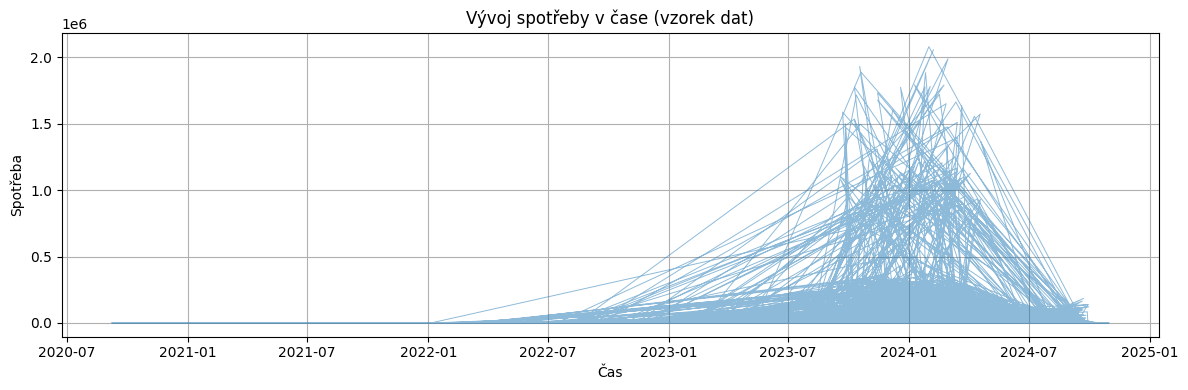

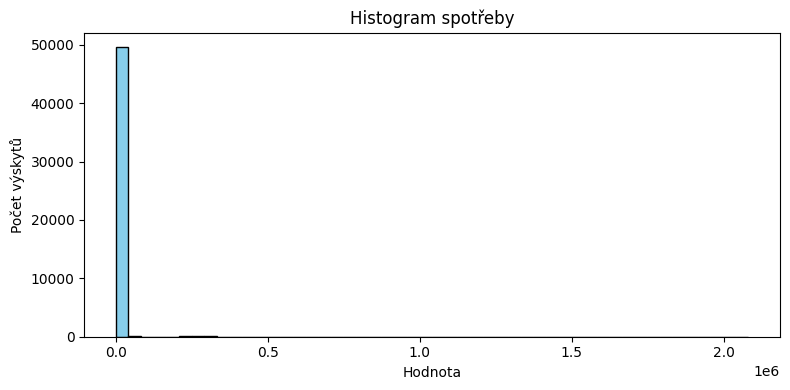

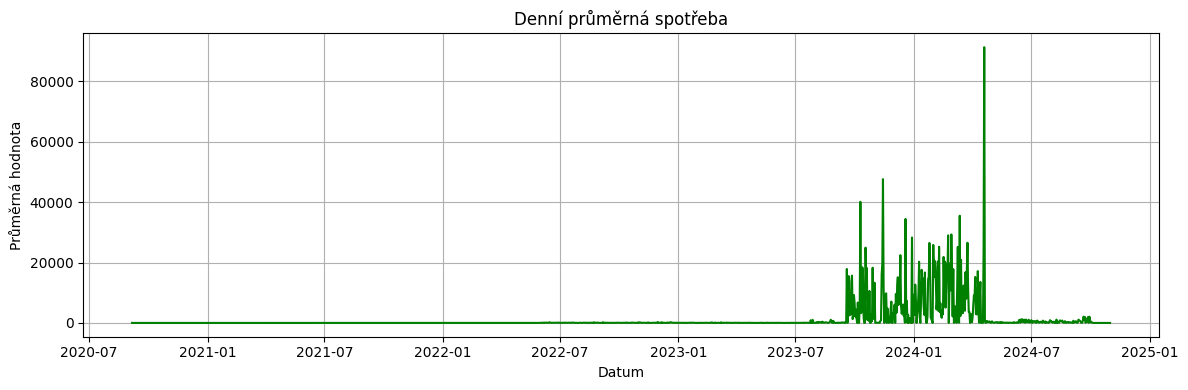

C:\Users\ondra\AppData\Local\Temp\ipykernel_16412\2681610660.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mean_per_id.index.astype(str), y=mean_per_id.values, palette="viridis")


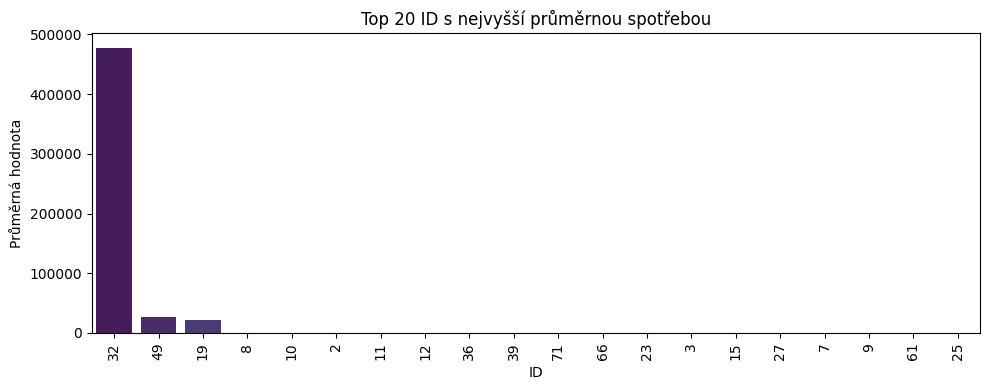

In [11]:
# Pro zrychlení - použij jen vzorek dat (např. 50 000 řádků)
df_sample = df_raw.sample(n=50000, random_state=42) if len(df_raw) > 50000 else df_raw.copy()

# === 1. Vývoj hodnot v čase ===
plt.figure(figsize=(12, 4))
plt.plot(df_sample['v_ts'], df_sample['anonymized_value'], alpha=0.5, linewidth=0.7)
plt.title("Vývoj spotřeby v čase (vzorek dat)")
plt.xlabel("Čas")
plt.ylabel("Spotřeba")
plt.grid(True)
plt.tight_layout()
plt.show()

# === 2. Histogram spotřeby ===
plt.figure(figsize=(8, 4))
plt.hist(df_sample['anonymized_value'], bins=50, color='skyblue', edgecolor='black')
plt.title("Histogram spotřeby")
plt.xlabel("Hodnota")
plt.ylabel("Počet výskytů")
plt.tight_layout()
plt.show()

# === 3. Denní průměr ===
daily_avg = df_sample.groupby('datum')['anonymized_value'].mean()
plt.figure(figsize=(12, 4))
plt.plot(daily_avg.index, daily_avg.values, color='green')
plt.title("Denní průměrná spotřeba")
plt.xlabel("Datum")
plt.ylabel("Průměrná hodnota")
plt.grid(True)
plt.tight_layout()
plt.show()

# === 4. Průměr podle ID ===
mean_per_id = df_sample.groupby('id_numeric')['anonymized_value'].mean().sort_values(ascending=False).head(20)
plt.figure(figsize=(10, 4))
sns.barplot(x=mean_per_id.index.astype(str), y=mean_per_id.values, palette="viridis")
plt.xticks(rotation=90)
plt.title("Top 20 ID s nejvyšší průměrnou spotřebou")
plt.xlabel("ID")
plt.ylabel("Průměrná hodnota")
plt.tight_layout()
plt.show()

Počet záznamů mezi 2022-01-01 a 2023-12-31: 4927584


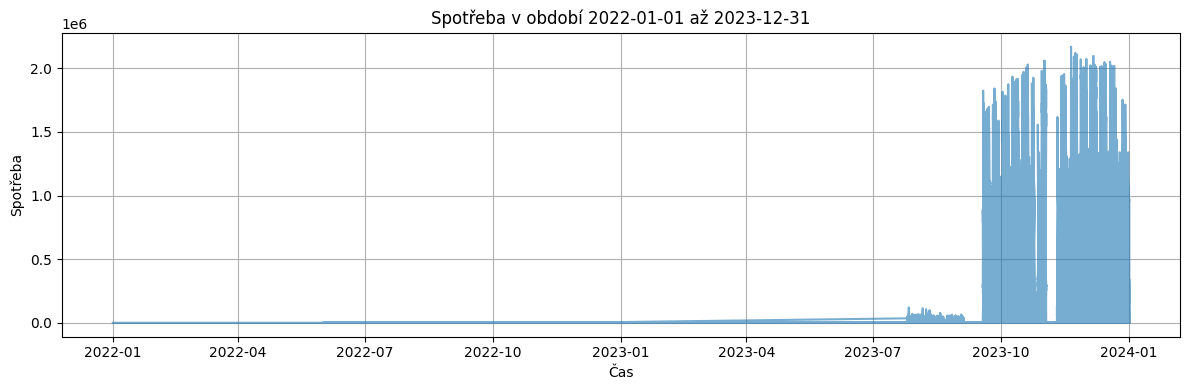

In [12]:
# Vyber konkrétní období
start_date = "2022-01-01"
end_date = "2023-12-31"

df_period = df_raw[(df_raw['datum'] >= start_date) & (df_raw['datum'] <= end_date)]

print(f"Počet záznamů mezi {start_date} a {end_date}: {len(df_period)}")

# Vývoj spotřeby v čase pro vybrané období
plt.figure(figsize=(12, 4))
plt.plot(df_period['v_ts'], df_period['anonymized_value'], alpha=0.6)
plt.title(f"Spotřeba v období {start_date} až {end_date}")
plt.xlabel("Čas")
plt.ylabel("Spotřeba")
plt.grid(True)
plt.tight_layout()
plt.show()


In [15]:
def perform_clustering(data, n_clusters=68):
    features = ["anonymized_value", "hour", "day", "month"]
    X = data[features]
    
    # Normalizace
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(X_scaled)
    
    # Výpočet silhouette score pro hodnocení kvality clusterů
    silhouette_avg = silhouette_score(X_scaled, clusters)
    print(f"Silhouette Score: {silhouette_avg:.3f}")
    
    return clusters, kmeans


In [16]:
def analyze_clusters(data):
    # Statistiky clusterů
    cluster_stats = data.groupby('cluster')['anonymized_value'].agg(['mean', 'std', 'count'])
    
    # Přidání typů dnů do analýzy
    cluster_day_types = data.groupby(['cluster', 'pracovni_den']).size().unstack()
    
    # Vizualizace
    plt.figure(figsize=(12, 6))
    plt.bar(cluster_stats.index, cluster_stats['mean'])
    plt.title('Průměrná spotřeba energie podle clusteru')
    plt.xlabel('Cluster')
    plt.ylabel('Průměrná spotřeba')
    plt.show()
    
    return cluster_stats, cluster_day_types

Silhouette Score (sample): 0.248


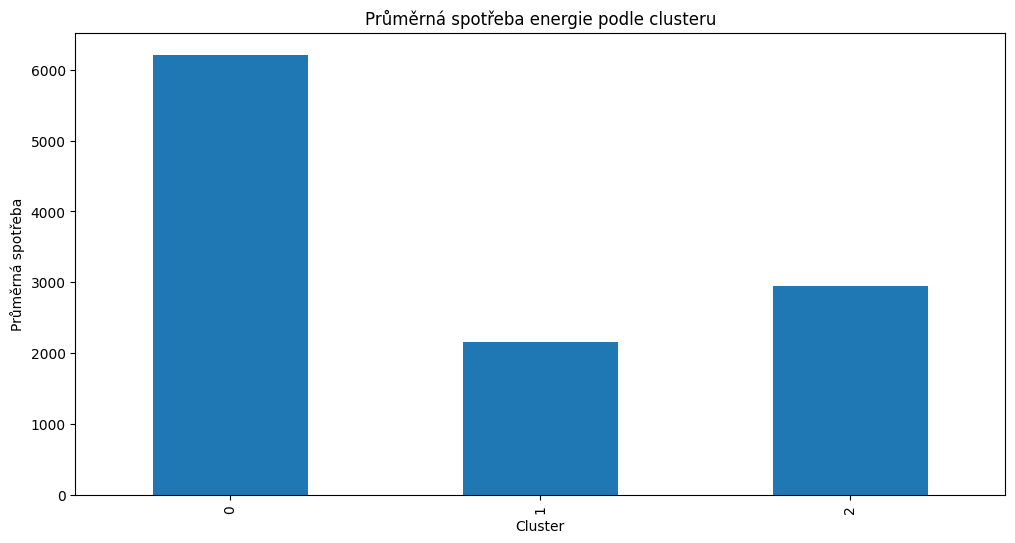

In [17]:

def perform_clustering_optimized(df, n_clusters=3, sample_size=10000):
    # Základní kontrola a doplnění časových složek
    df = df.copy()
    df = df.dropna(subset=['anonymized_value', 'v_ts'])  # odstranění chybějících hodnot
    
    df['hour'] = df['v_ts'].dt.hour
    df['day'] = df['v_ts'].dt.day
    df['month'] = df['v_ts'].dt.month

    # Výběr feature a sampling (pro rychlejší výpočet)
    features = ["anonymized_value", "hour", "day", "month"]
    df_sample = df.sample(n=min(sample_size, len(df)), random_state=42)

    X = df_sample[features]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Rychlejší k-means pomocí MiniBatch
    kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42, batch_size=1000)
    sample_clusters = kmeans.fit_predict(X_scaled)

    # Aplikace modelu na celé df
    X_all_scaled = scaler.transform(df[features])
    df['cluster'] = kmeans.predict(X_all_scaled)

    # Výpočet silhouette score jen pro vzorek
    silhouette_avg = silhouette_score(X_scaled, sample_clusters)
    print(f"Silhouette Score (sample): {silhouette_avg:.3f}")

    return df, kmeans
df_combined, model = perform_clustering_optimized(df_combined, n_clusters=3, sample_size=10000)
def analyze_clusters(df):
    stats = df.groupby('cluster')['anonymized_value'].agg(['mean', 'std', 'count'])
    day_types = df.groupby(['cluster', 'pracovni_den']).size().unstack()
    
    stats.plot(kind='bar', y='mean', figsize=(12, 6), legend=False)
    plt.title('Průměrná spotřeba energie podle clusteru')
    plt.xlabel('Cluster')
    plt.ylabel('Průměrná spotřeba')
    plt.show()
    
    return stats, day_types
cluster_stats, cluster_day_types = analyze_clusters(df_combined)

In [18]:
def analyze_clusters(df):
    stats = df.groupby('cluster')['anonymized_value'].agg(['mean', 'std', 'count'])
    day_types = df.groupby(['cluster', 'pracovni_den']).size().unstack()
    
    stats.plot(kind='bar', y='mean', figsize=(12, 6), legend=False)
    plt.title('Průměrná spotřeba energie podle clusteru')
    plt.xlabel('Cluster')
    plt.ylabel('Průměrná spotřeba')
    plt.show()
    
    return stats, day_types  # ← MUSÍ tu být obě návratové hodnoty


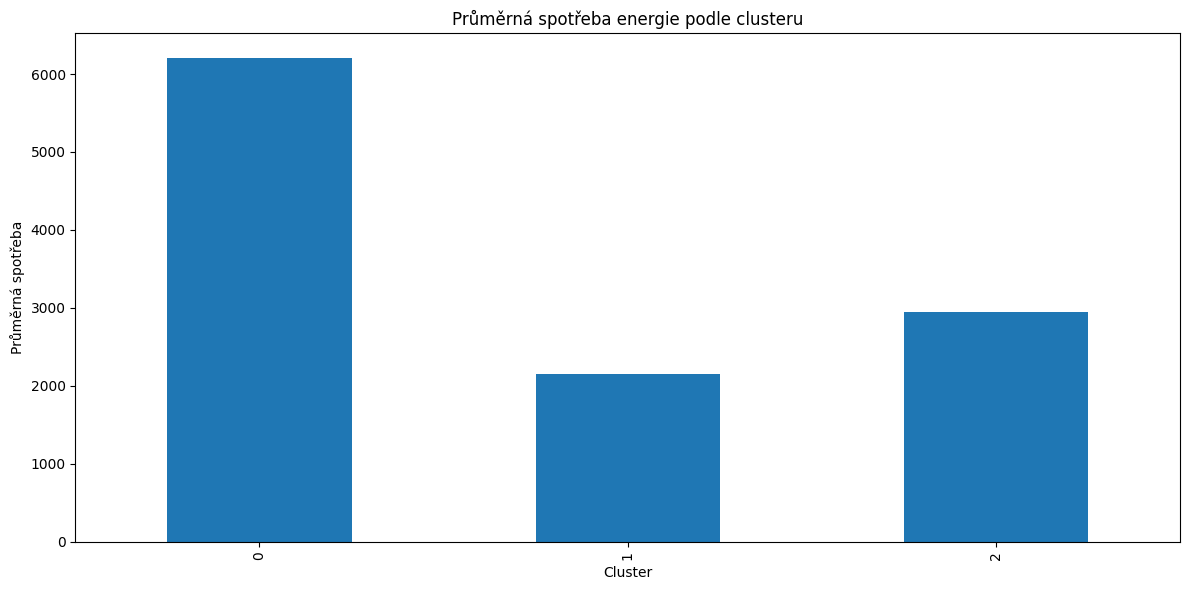

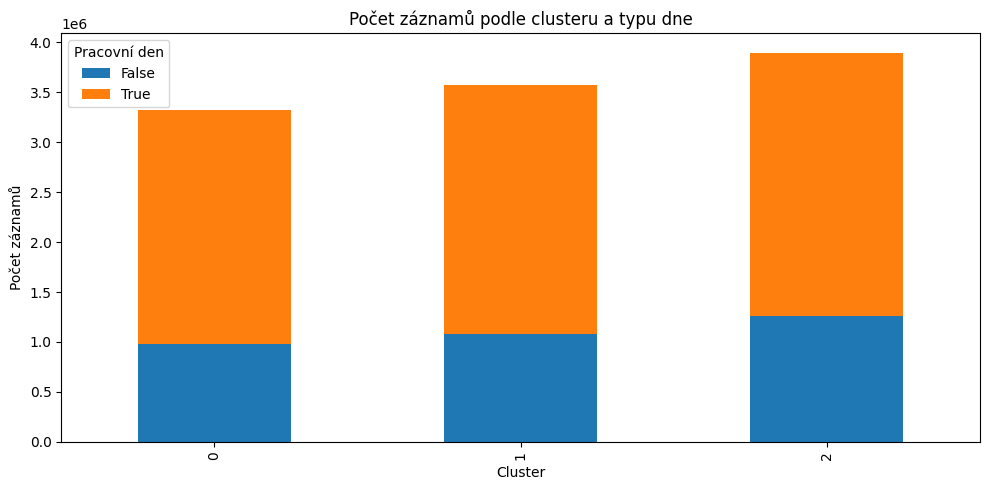

In [20]:

def analyze_clusters_safe(df):
    # Statistika podle clusteru
    stats = df.groupby('cluster')['anonymized_value'].agg(['mean', 'std', 'count'])

    # Vykreslení sloupcového grafu
    stats.plot(kind='bar', y='mean', figsize=(12, 6), legend=False)
    plt.title('Průměrná spotřeba energie podle clusteru')
    plt.xlabel('Cluster')
    plt.ylabel('Průměrná spotřeba')
    plt.tight_layout()
    plt.show()

    # Rozdělení podle typu dne, pokud existuje sloupec 'pracovni_den'
    if 'pracovni_den' in df.columns:
        day_types = df.groupby(['cluster', 'pracovni_den']).size().unstack(fill_value=0)
        
        day_types.plot(kind='bar', stacked=True, figsize=(10, 5))
        plt.title('Počet záznamů podle clusteru a typu dne')
        plt.xlabel('Cluster')
        plt.ylabel('Počet záznamů')
        plt.legend(title='Pracovní den')
        plt.tight_layout()
        plt.show()
    else:
        print("Sloupec 'pracovni_den' nebyl nalezen, přeskakuji analýzu typu dne.")
        day_types = None

    return stats, day_types
cluster_stats, cluster_day_types = analyze_clusters_safe(df_combined)


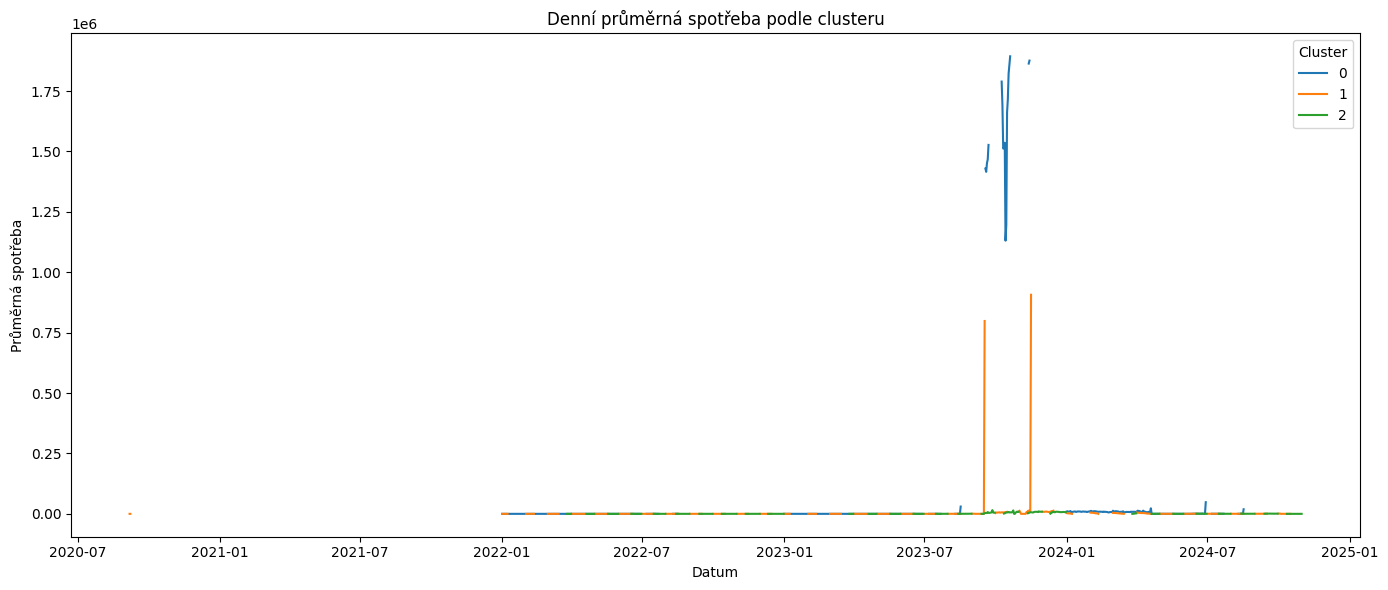

In [21]:
def analyze_clusters_by_date_lineplot(df):
    # Ujisti se, že sloupec v_ts je datetime
    if not pd.api.types.is_datetime64_any_dtype(df['v_ts']):
        df['v_ts'] = pd.to_datetime(df['v_ts'], errors='coerce')

    df['date'] = df['v_ts'].dt.date

    # Výpočet průměrné hodnoty anonymized_value podle clusteru a data
    daily_avg = df.groupby(['date', 'cluster'])['anonymized_value'].mean().unstack()

    # Vykreslení čárového grafu
    daily_avg.plot(figsize=(14, 6))
    plt.title('Denní průměrná spotřeba podle clusteru')
    plt.xlabel('Datum')
    plt.ylabel('Průměrná spotřeba')
    plt.legend(title='Cluster')
    plt.tight_layout()
    plt.show()

    return daily_avg
# Po denní ose
daily_avg = analyze_clusters_by_date_lineplot(df_combined)

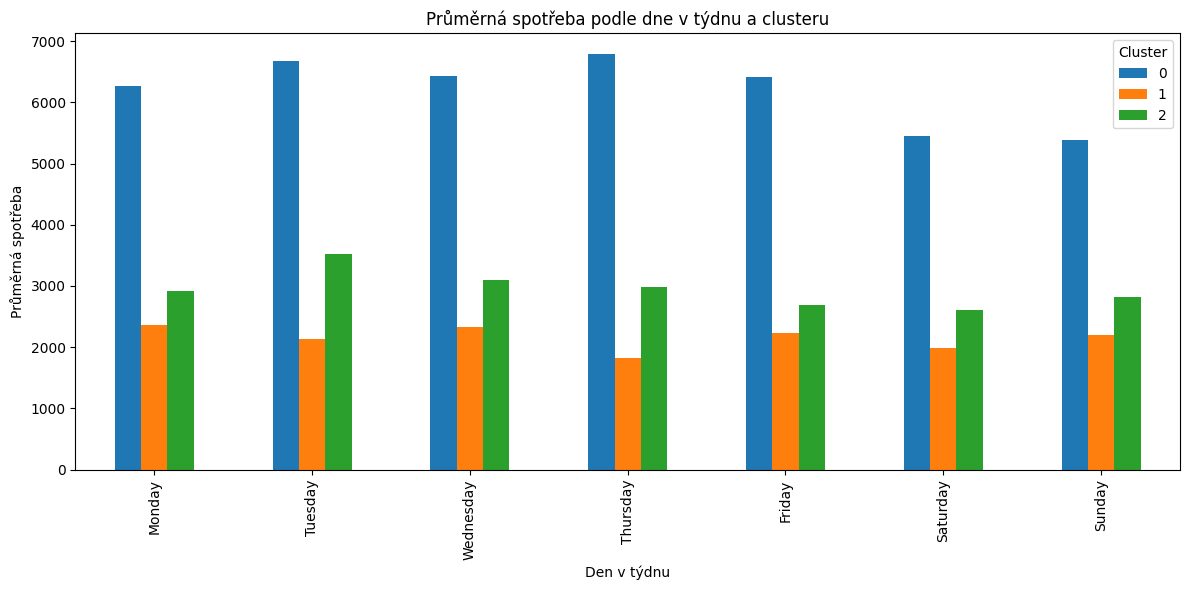

In [22]:
def analyze_clusters_by_weekday(df):
    # Převedení času a vytvoření názvu dne
    if not pd.api.types.is_datetime64_any_dtype(df['v_ts']):
        df['v_ts'] = pd.to_datetime(df['v_ts'], errors='coerce')

    df['weekday'] = df['v_ts'].dt.day_name()  # např. 'Monday', 'Tuesday'

    # Uspořádání názvů dnů v týdnu (pro správné pořadí)
    weekdays_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    df['weekday'] = pd.Categorical(df['weekday'], categories=weekdays_order, ordered=True)

    # Výpočet průměrné spotřeby podle dne v týdnu a clusteru
    weekday_avg = df.groupby(['weekday', 'cluster'])['anonymized_value'].mean().unstack()

    # Vykreslení
    weekday_avg.plot(kind='bar', figsize=(12, 6))
    plt.title('Průměrná spotřeba podle dne v týdnu a clusteru')
    plt.xlabel('Den v týdnu')
    plt.ylabel('Průměrná spotřeba')
    plt.legend(title='Cluster')
    plt.tight_layout()
    plt.show()

    return weekday_avg
weekday_avg = analyze_clusters_by_weekday(df_combined)

Silhouette Score (sample): 0.235


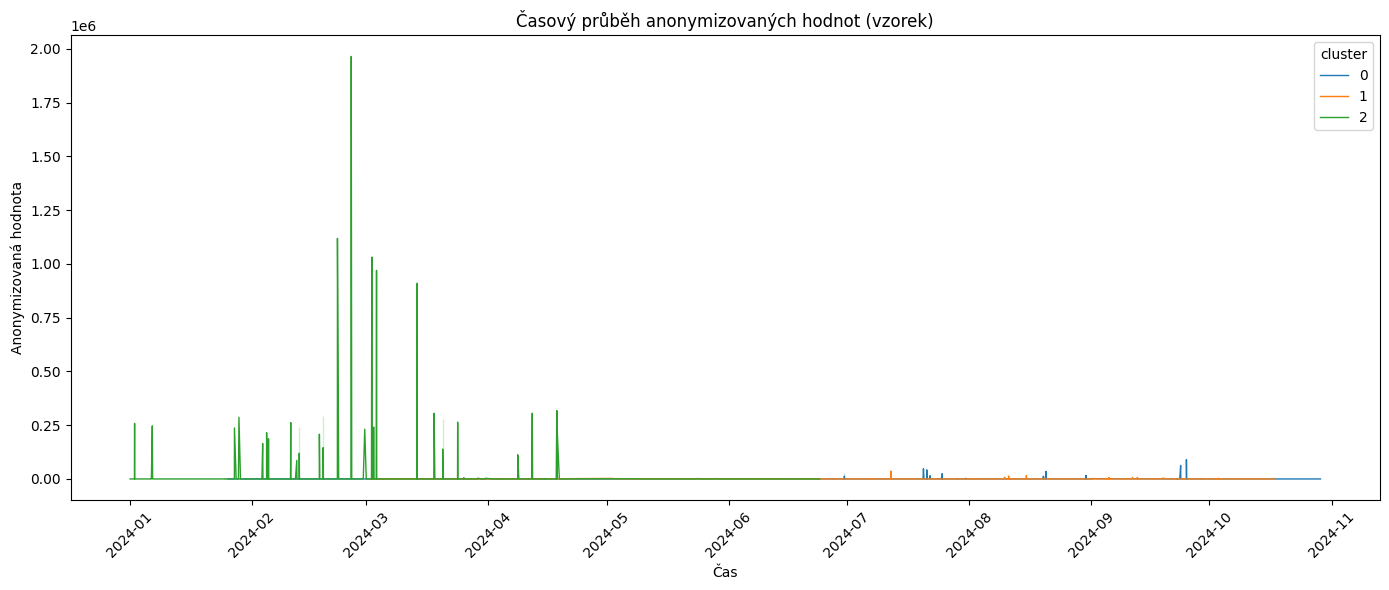

In [23]:
def full_clustering_pipeline(df, n_clusters=3, sample_size=10000, plot_sample_size=5000, date_filter=None, plot=True):
    
    # Kopie a filtrace podle datumu (např. posledních 30 dní)
    df = df.copy()
    df = df.dropna(subset=['anonymized_value', 'v_ts'])
    
    if not pd.api.types.is_datetime64_any_dtype(df['v_ts']):
        df['v_ts'] = pd.to_datetime(df['v_ts'], errors='coerce')
    
    if date_filter is not None:
        df = df[df['v_ts'] >= pd.to_datetime(date_filter)]

    # Časové složky
    df['hour'] = df['v_ts'].dt.hour
    df['day'] = df['v_ts'].dt.day
    df['month'] = df['v_ts'].dt.month

    # Clustering na vzorku
    features = ['anonymized_value', 'hour', 'day', 'month']
    df_sample = df.sample(n=min(sample_size, len(df)), random_state=42)
    X_sample = df_sample[features]

    scaler = StandardScaler()
    X_sample_scaled = scaler.fit_transform(X_sample)

    kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42, batch_size=1000)
    sample_clusters = kmeans.fit_predict(X_sample_scaled)

    # Aplikace na celý dataset
    X_all_scaled = scaler.transform(df[features])
    df['cluster'] = kmeans.predict(X_all_scaled)

    # Silhouette score (vzorek)
    silhouette_avg = silhouette_score(X_sample_scaled, sample_clusters)
    print(f"Silhouette Score (sample): {silhouette_avg:.3f}")

    # Rychlejší vykreslení (jen vzorek, pokud je plot zapnutý)
    if plot:
        df_plot = df.sample(n=min(plot_sample_size, len(df)), random_state=123)
        plt.figure(figsize=(14, 6))
        sns.lineplot(data=df_plot, x='v_ts', y='anonymized_value', hue='cluster', palette='tab10', linewidth=1)
        plt.title('Časový průběh anonymizovaných hodnot (vzorek)')
        plt.xlabel('Čas')
        plt.ylabel('Anonymizovaná hodnota')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    return df, kmeans

df_clustered, model = full_clustering_pipeline(df_raw, n_clusters=3, sample_size=5000, plot_sample_size=3000, date_filter='2024-01-01')


✅ Silhouette Score (vzorek): 0.233


C:\Users\ondra\AppData\Local\Temp\ipykernel_16412\1314365894.py:51: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ondra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


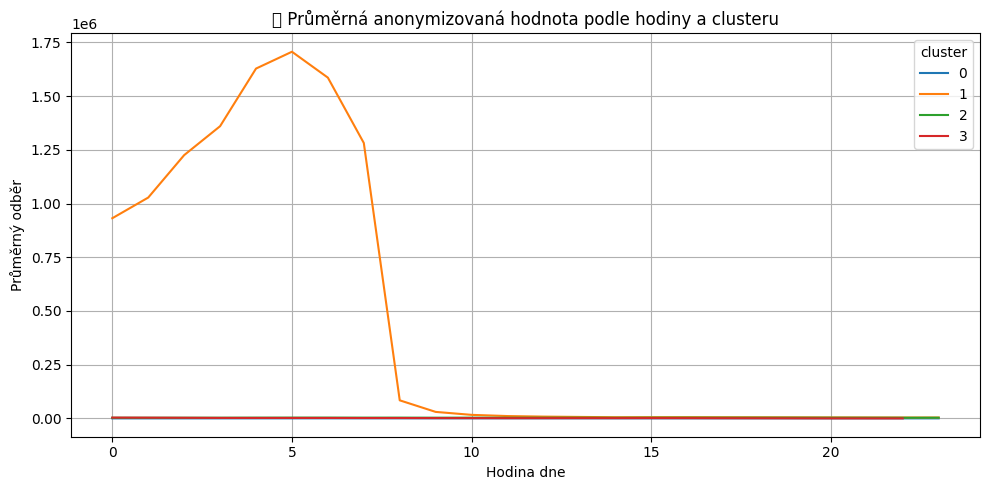

C:\Users\ondra\AppData\Local\Temp\ipykernel_16412\1314365894.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='cluster', palette='tab10')
C:\Users\ondra\AppData\Local\Temp\ipykernel_16412\1314365894.py:60: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ondra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


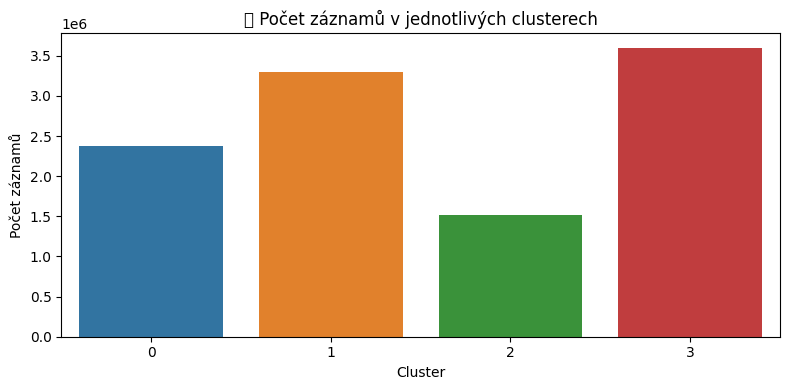

In [24]:
def fast_clustering_pipeline(df, n_clusters=3, sample_size=10000, plot_graph=True):


    # --- Příprava dat ---
    df = df[['v_ts', 'anonymized_value']].dropna().copy()
    timestamps = pd.to_datetime(df['v_ts'] // 10**9, unit='s')
    df['hour'] = timestamps.dt.hour
    df['day'] = timestamps.dt.day
    df['month'] = timestamps.dt.month
    df['weekday'] = timestamps.dt.weekday
    df['date'] = timestamps.dt.date
    df['datetime'] = timestamps

    cz_holidays = holidays.CountryHoliday('CZ')
    holiday_dates = set(cz_holidays)
    df['is_holiday'] = df['date'].isin(holiday_dates).astype(np.uint8)
    df['is_saturday'] = (df['weekday'] == 5).astype(np.uint8)
    df['is_sunday'] = (df['weekday'] == 6).astype(np.uint8)
    df['is_vacation'] = df['month'].isin([7, 8]).astype(np.uint8)
    df['is_workday'] = (~df['is_holiday'] & ~df['is_saturday'] & ~df['is_sunday']).astype(np.uint8)

    features = [
        'anonymized_value', 'hour', 'day', 'month',
        'is_workday', 'is_saturday', 'is_sunday', 'is_holiday', 'is_vacation'
    ]

    # --- Clustering ---
    df_sample = df.sample(n=min(sample_size, len(df)), random_state=42)
    X_sample = df_sample[features]
    scaler = StandardScaler()
    X_sample_scaled = scaler.fit_transform(X_sample)
    kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42, batch_size=1000)
    sample_clusters = kmeans.fit_predict(X_sample_scaled)
    X_all_scaled = scaler.transform(df[features])
    df['cluster'] = kmeans.predict(X_all_scaled)
    silhouette_avg = silhouette_score(X_sample_scaled, sample_clusters)
    print(f"✅ Silhouette Score (vzorek): {silhouette_avg:.3f}")

    # --- Grafy ---
    if plot_graph:
        # 1️⃣ Průměrné odběry podle hodiny a clusteru
        plt.figure(figsize=(10, 5))
        sns.lineplot(
            data=df.groupby(['hour', 'cluster'])['anonymized_value'].mean().reset_index(),
            x='hour', y='anonymized_value', hue='cluster', palette='tab10'
        )
        plt.title('📊 Průměrná anonymizovaná hodnota podle hodiny a clusteru')
        plt.xlabel('Hodina dne')
        plt.ylabel('Průměrný odběr')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # 2️⃣ Histogram četnosti záznamů v clusterech
        plt.figure(figsize=(8, 4))
        sns.countplot(data=df, x='cluster', palette='tab10')
        plt.title('📦 Počet záznamů v jednotlivých clusterech')
        plt.xlabel('Cluster')
        plt.ylabel('Počet záznamů')
        plt.tight_layout()
        plt.show()

    return df, kmeans
df_clustered, model = fast_clustering_pipeline(data, n_clusters=4, sample_size=5000, plot_graph=True)


C:\Users\ondra\AppData\Local\Temp\ipykernel_16412\577699219.py:58: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ondra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


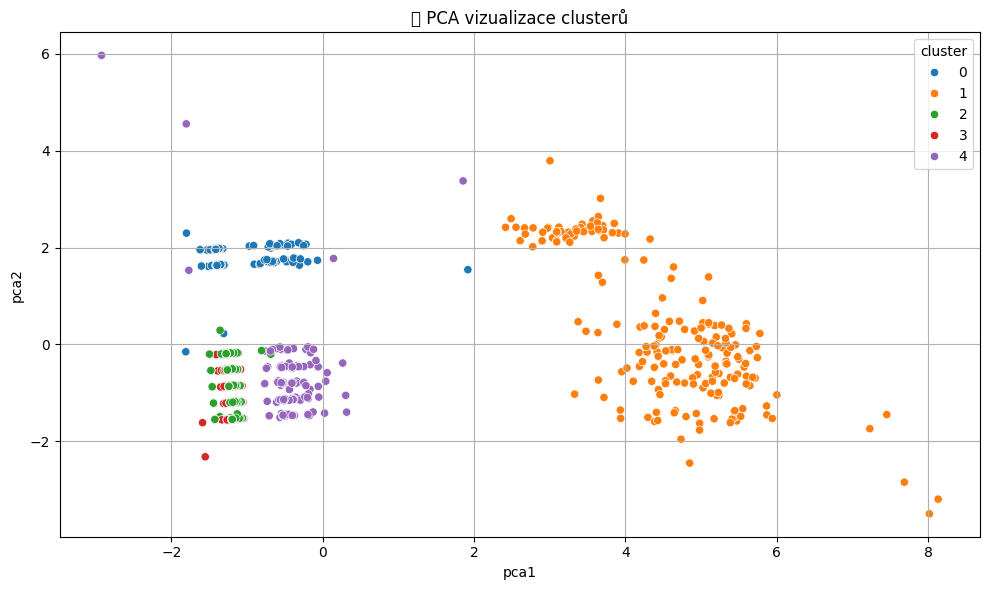

C:\Users\ondra\AppData\Local\Temp\ipykernel_16412\577699219.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=daily, x='cluster', y='val_sum', palette='Set2')
C:\Users\ondra\AppData\Local\Temp\ipykernel_16412\577699219.py:64: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ondra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


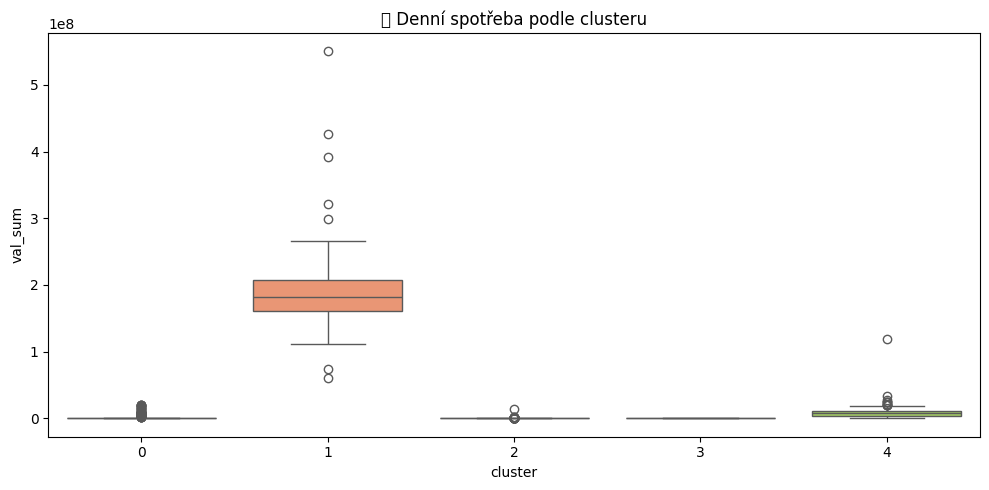

In [25]:
def advanced_clustering_and_plot(df, n_clusters=5):
    df = df.copy()

    # Časová příprava
    df['date'] = df['v_ts'].dt.date
    df['hour'] = df['v_ts'].dt.hour
    df['weekday'] = df['v_ts'].dt.weekday
    df['month'] = df['v_ts'].dt.month

    # Svátky a víkendy
    cz_holidays = holidays.CountryHoliday('CZ')
    df['is_holiday'] = df['date'].isin(cz_holidays).astype(int)
    df['is_weekend'] = df['weekday'].isin([5, 6]).astype(int)

    # Denní agregace
    daily = df.groupby('date').agg({
        'anonymized_value': ['mean', 'max', 'min', 'std', 'sum'],
        'hour': 'nunique',
        'is_holiday': 'max',
        'is_weekend': 'max',
        'month': 'first',
        'weekday': 'first'
    }).reset_index()

    daily.columns = ['date', 'val_mean', 'val_max', 'val_min', 'val_std', 'val_sum',
                     'hours_active', 'is_holiday', 'is_weekend', 'month', 'weekday']

    # Příznaky (feature engineering)
    daily['val_range'] = daily['val_max'] - daily['val_min']
    daily['val_cv'] = daily['val_std'] / (daily['val_mean'] + 1e-5)
    daily['delta_val_sum'] = daily['val_sum'].diff().fillna(0)
    daily['delta_val_mean'] = daily['val_mean'].diff().fillna(0)

    features = [
        'val_mean', 'val_max', 'val_min', 'val_std', 'val_sum',
        'val_range', 'val_cv', 'delta_val_sum', 'delta_val_mean',
        'hours_active', 'is_holiday', 'is_weekend', 'month', 'weekday'
    ]

    # Standardizace a clustering
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(daily[features])
    kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42, batch_size=100)
    clusters = kmeans.fit_predict(X_scaled)
    daily['cluster'] = clusters

    # PCA pro vizualizaci
    pca = PCA(n_components=2)
    pca_coords = pca.fit_transform(X_scaled)
    daily['pca1'] = pca_coords[:, 0]
    daily['pca2'] = pca_coords[:, 1]

    # 📊 Vizualizace
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=daily, x='pca1', y='pca2', hue='cluster', palette='tab10')
    plt.title('🧠 PCA vizualizace clusterů')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 5))
    sns.boxplot(data=daily, x='cluster', y='val_sum', palette='Set2')
    plt.title('📦 Denní spotřeba podle clusteru')
    plt.tight_layout()
    plt.show()

    return daily, kmeans, scaler, pca
daily_clusters, cluster_model, scaler_model, pca_model = advanced_clustering_and_plot(df_raw, n_clusters=5)

C:\Users\ondra\AppData\Local\Temp\ipykernel_16412\2175325042.py:22: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ondra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


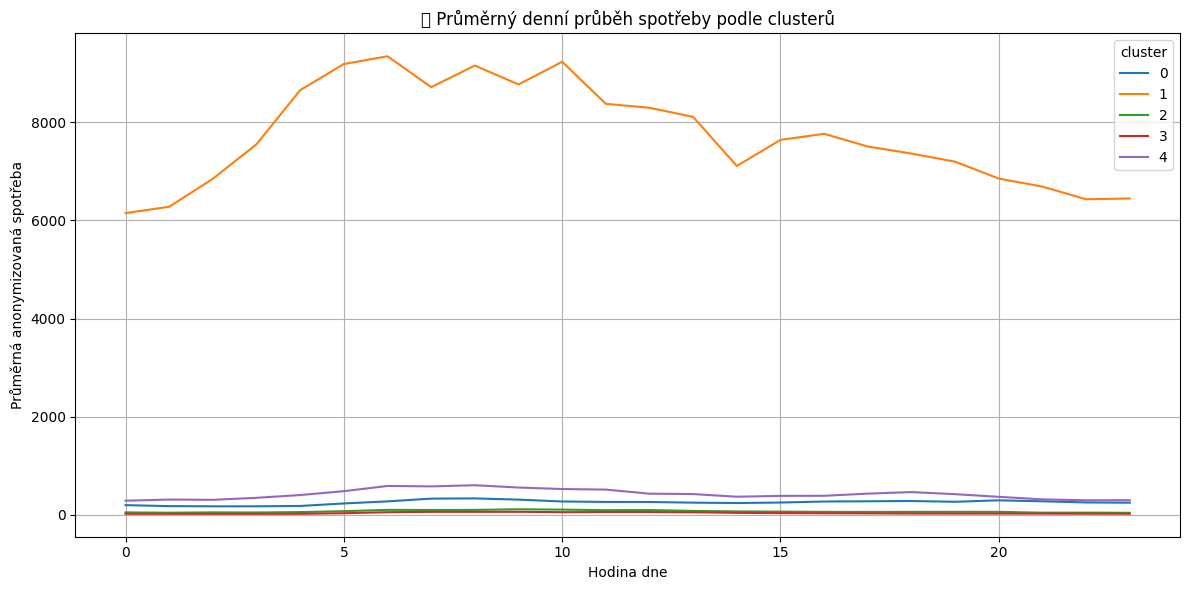

🗓️ Typické dny podle vzdálenosti od centroidu:
🔸 Cluster 0: 2024-10-31
🔸 Cluster 1: 2023-09-23
🔸 Cluster 2: 2022-05-27
🔸 Cluster 3: 2022-01-24
🔸 Cluster 4: 2022-01-31


In [26]:
def plot_typical_day_profiles(df_raw, daily_clusters):
    # Spojíme denní cluster zpět do původního dataframe
    df = df_raw.copy()
    df['date'] = df['v_ts'].dt.date
    cluster_map = daily_clusters.set_index('date')['cluster']
    df['cluster'] = df['date'].map(cluster_map)

    # Odebereme dny bez přiřazeného clusteru
    df = df.dropna(subset=['cluster'])
    df['cluster'] = df['cluster'].astype(int)

    # 1️⃣ Průměrný hodinový průběh spotřeby pro každý cluster
    hourly_profile = df.groupby(['cluster', df['v_ts'].dt.hour])['anonymized_value'].mean().reset_index()
    hourly_profile.columns = ['cluster', 'hour', 'mean_value']

    plt.figure(figsize=(12, 6))
    sns.lineplot(data=hourly_profile, x='hour', y='mean_value', hue='cluster', palette='tab10')
    plt.title('📈 Průměrný denní průběh spotřeby podle clusterů')
    plt.xlabel('Hodina dne')
    plt.ylabel('Průměrná anonymizovaná spotřeba')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 2️⃣ Typický den v každém clusteru (nejbližší průměrným hodnotám)
    print("🗓️ Typické dny podle vzdálenosti od centroidu:")
    features = [
        'val_mean', 'val_max', 'val_min', 'val_std', 'val_sum',
        'val_range', 'val_cv', 'delta_val_sum', 'delta_val_mean',
        'hours_active', 'is_holiday', 'is_weekend', 'month', 'weekday'
    ]
    X_scaled = daily_clusters[features].values
    centroids = cluster_model.cluster_centers_

    for cluster_id in sorted(daily_clusters['cluster'].unique()):
        cluster_data = daily_clusters[daily_clusters['cluster'] == cluster_id]
        idx = cluster_data.index
        distances = np.linalg.norm(X_scaled[idx] - centroids[cluster_id], axis=1)
        min_idx = idx[np.argmin(distances)]
        typical_day = daily_clusters.loc[min_idx, 'date']
        print(f"🔸 Cluster {cluster_id}: {typical_day}")
plot_typical_day_profiles(df_raw, daily_clusters)

LSTM model pro rychlejší načítání a jednu predikci + spojení kalendářů

In [61]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import holidays

# --- Načtení a příprava dat ---
def load_and_prepare_data(filepath, limit=10000):
    df = pd.read_csv(filepath)
    df['v_ts'] = pd.to_datetime(df['v_ts'], errors='coerce')  # Zajistíme, že sloupec 'v_ts' je v datetime formátu
    df = df.sort_values('v_ts')
    df = df[['v_ts', 'anonymized_value']].head(limit)  # Zmenšení dat pro rychlé testování
    return df

# --- Generování kalendáře pro ČR ---
def generate_czech_calendar(year):
    cz_holidays = holidays.Czechia(years=year)
    dates = pd.date_range(start=f'{year}-01-01', end=f'{year}-12-31')
    
    calendar_df = pd.DataFrame({
        'datum': dates,
        'den_v_tydnu': dates.day_name(),
        'statni_svatek': [date in cz_holidays for date in dates],
        'skolni_prazdniny': [date.month in [7, 8] for date in dates]  # Jednoduchá podmínka pro prázdniny
    })
    
    calendar_df['pracovni_den'] = calendar_df['den_v_tydnu'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']) & (~calendar_df['statni_svatek'])
    return calendar_df

def generate_calendar_range(start_year, end_year):
    calendars = []
    for year in range(start_year, end_year + 1):
        calendars.append(generate_czech_calendar(year))
    return pd.concat(calendars)

# Generujeme kalendář pro roky 2022-2024
df_calendar = generate_calendar_range(2022, 2024)

# --- Sloučení datového rámce s kalendářem ---
def merge_with_calendar(df_data, df_calendar):
    # Převeďme sloupec 'v_ts' na datetime64[ns], pokud ještě není
    df_data['v_ts'] = pd.to_datetime(df_data['v_ts'], errors='coerce')  # 'errors=coerce' převede nevalidní hodnoty na NaT

    # Převeďme sloupec 'datum' v kalendáři na datetime64[ns]
    df_calendar['datum'] = pd.to_datetime(df_calendar['datum'], errors='coerce')

    # Pouze datum (bez času) pro sloučení
    df_data['datum'] = df_data['v_ts'].dt.date

    # Převedení na datetime pro sloučení
    df_data['datum'] = pd.to_datetime(df_data['datum'])

    # Sloučení na základě 'datum'
    df_combined = pd.merge(df_data, df_calendar, on='datum', how='left')
    
    return df_combined

# Načteme data a sloučíme je s kalendářem
df_raw = load_and_prepare_data("C:\\Users\\ondra\\OneDrive\\Plocha\\DataOdectyDecin20241011.csv")
df_combined = merge_with_calendar(df_raw, df_calendar)

# --- Normalizace a příprava sekvencí pro model ---
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# --- LSTM model ---
def build_and_train_lstm(X, y, seq_length, epochs=5):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(seq_length, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=epochs, batch_size=32, verbose=0)
    return model

# --- Hlavní pipeline ---
def lstm_pipeline(filepath, seq_length=24, sample_limit=10000):
    # Načteme data
    df = load_and_prepare_data(filepath, limit=sample_limit)

    # Normalizace
    scaler = MinMaxScaler()
    values_scaled = scaler.fit_transform(df[['anonymized_value']].values)

    # Vytvoření sekvencí pro LSTM
    X, y = create_sequences(values_scaled, seq_length)
    X = X.reshape((X.shape[0], X.shape[1], 1))

    # Trénování modelu
    model = build_and_train_lstm(X, y, seq_length)

    # Predikce na posledních sekvencích
    last_seq = values_scaled[-seq_length:]
    next_value_scaled = model.predict(last_seq.reshape(1, seq_length, 1))
    next_value_real = scaler.inverse_transform(next_value_scaled)

    print(f"🔮 Predikovaná další hodnota spotřeby: {next_value_real[0][0]:.2f}")

# Spuštění pipeline
lstm_pipeline("C:\\Users\\ondra\\OneDrive\\Plocha\\DataOdectyDecin20241011.csv")


C:\Users\ondra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 0s 42ms/step
🔮 Predikovaná další hodnota spotřeby: 0.32


C:\Users\ondra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 0s 43ms/step
🔮 Predikovaná další hodnota spotřeby: -0.05
2/2 [==============================] - 0s 34ms/step


C:\Users\ondra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


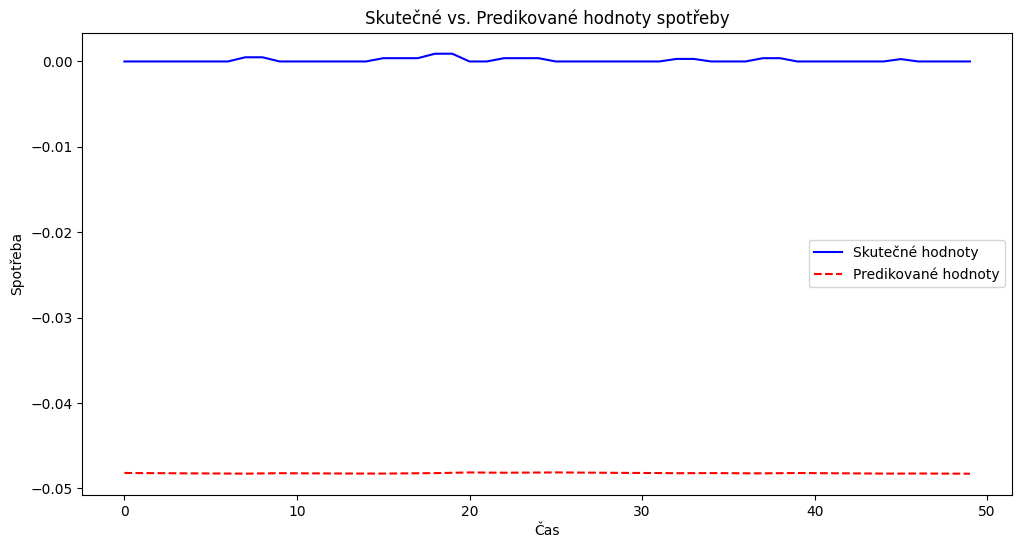

In [62]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import holidays
import matplotlib.pyplot as plt

# --- Načtení a příprava dat ---
def load_and_prepare_data(filepath, limit=10000):
    df = pd.read_csv(filepath)
    df['v_ts'] = pd.to_datetime(df['v_ts'], errors='coerce')  # Zajistíme, že sloupec 'v_ts' je v datetime formátu
    df = df.sort_values('v_ts')
    df = df[['v_ts', 'anonymized_value']].head(limit)  # Zmenšení dat pro rychlé testování
    return df

# --- Generování kalendáře pro ČR ---
def generate_czech_calendar(year):
    cz_holidays = holidays.Czechia(years=year)
    dates = pd.date_range(start=f'{year}-01-01', end=f'{year}-12-31')
    
    calendar_df = pd.DataFrame({
        'datum': dates,
        'den_v_tydnu': dates.day_name(),
        'statni_svatek': [date in cz_holidays for date in dates],
        'skolni_prazdniny': [date.month in [7, 8] for date in dates]  # Jednoduchá podmínka pro prázdniny
    })
    
    calendar_df['pracovni_den'] = calendar_df['den_v_tydnu'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']) & (~calendar_df['statni_svatek'])
    return calendar_df

def generate_calendar_range(start_year, end_year):
    calendars = []
    for year in range(start_year, end_year + 1):
        calendars.append(generate_czech_calendar(year))
    return pd.concat(calendars)

# Generujeme kalendář pro roky 2022-2024
df_calendar = generate_calendar_range(2022, 2024)

# --- Sloučení datového rámce s kalendářem ---
def merge_with_calendar(df_data, df_calendar):
    # Převeďme sloupec 'v_ts' na datetime64[ns], pokud ještě není
    df_data['v_ts'] = pd.to_datetime(df_data['v_ts'], errors='coerce')  # 'errors=coerce' převede nevalidní hodnoty na NaT

    # Převeďme sloupec 'datum' v kalendáři na datetime64[ns]
    df_calendar['datum'] = pd.to_datetime(df_calendar['datum'], errors='coerce')

    # Pouze datum (bez času) pro sloučení
    df_data['datum'] = df_data['v_ts'].dt.date

    # Převedení na datetime pro sloučení
    df_data['datum'] = pd.to_datetime(df_data['datum'])

    # Sloučení na základě 'datum'
    df_combined = pd.merge(df_data, df_calendar, on='datum', how='left')
    
    return df_combined

# Načteme data a sloučíme je s kalendářem
df_raw = load_and_prepare_data("C:\\Users\\ondra\\OneDrive\\Plocha\\DataOdectyDecin20241011.csv")
df_combined = merge_with_calendar(df_raw, df_calendar)

# --- Normalizace a příprava sekvencí pro model ---
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# --- LSTM model ---
def build_and_train_lstm(X, y, seq_length, epochs=5):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(seq_length, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=epochs, batch_size=32, verbose=0)
    return model

# --- Hlavní pipeline ---
def lstm_pipeline(filepath, seq_length=24, sample_limit=10000):
    # Načteme data
    df = load_and_prepare_data(filepath, limit=sample_limit)

    # Normalizace
    scaler = MinMaxScaler()
    values_scaled = scaler.fit_transform(df[['anonymized_value']].values)

    # Vytvoření sekvencí pro LSTM
    X, y = create_sequences(values_scaled, seq_length)
    X = X.reshape((X.shape[0], X.shape[1], 1))

    # Trénování modelu
    model = build_and_train_lstm(X, y, seq_length)

    # Predikce na posledních sekvencích
    last_seq = values_scaled[-seq_length:]
    next_value_scaled = model.predict(last_seq.reshape(1, seq_length, 1))
    next_value_real = scaler.inverse_transform(next_value_scaled)

    print(f"🔮 Predikovaná další hodnota spotřeby: {next_value_real[0][0]:.2f}")

    # Vytvoření grafu: Skutečné hodnoty vs. predikované
    pred_values = model.predict(X[-50:].reshape((50, seq_length, 1)))
    pred_values_real = scaler.inverse_transform(pred_values)
    
    # Vytvoření grafu pro porovnání
    plt.figure(figsize=(12,6))
    plt.plot(np.arange(len(df['anonymized_value'][-50:])), df['anonymized_value'][-50:], label='Skutečné hodnoty', color='blue')
    plt.plot(np.arange(len(pred_values_real)), pred_values_real, label='Predikované hodnoty', color='red', linestyle='--')
    plt.title('Skutečné vs. Predikované hodnoty spotřeby')
    plt.xlabel('Čas')
    plt.ylabel('Spotřeba')
    plt.legend()
    plt.show()

# Spuštění pipeline
lstm_pipeline("C:\\Users\\ondra\\OneDrive\\Plocha\\DataOdectyDecin20241011.csv")


kod pro více predikcí 

C:\Users\ondra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 0s 43ms/step


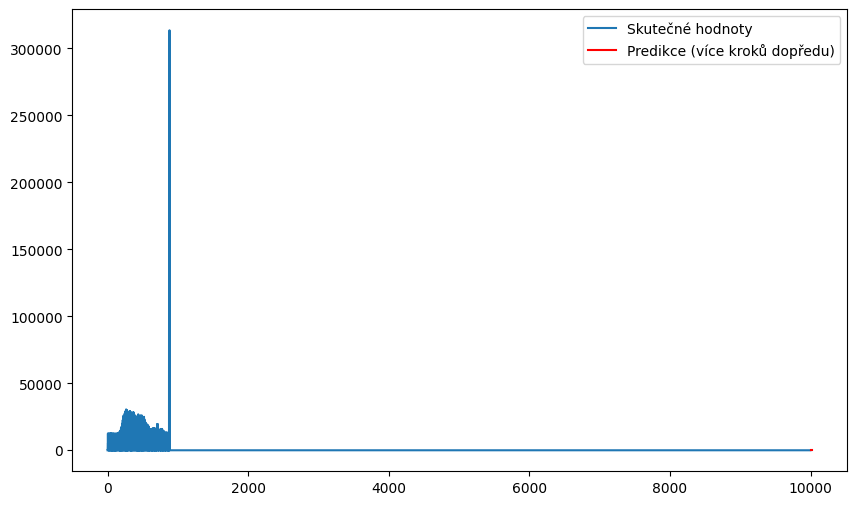

🔮 Predikované hodnoty spotřeby na 24 kroků dopředu: [-1.0497347 -1.0966711 -1.1338668 -1.1639756 -1.188425  -1.2083362
 -1.2245901 -1.2378855 -1.2487819 -1.2577248 -1.2650764 -1.271127
 -1.276109  -1.2802179 -1.2836093 -1.2864066 -1.2887175 -1.2906278
 -1.2922069 -1.2935113 -1.2945923 -1.2954841 -1.2962804 -1.2969526]


In [35]:


# --- Predikce více kroků dopředu ---
def predict_multiple_steps(model, last_seq, steps, scaler):
    predictions = []
    current_input = last_seq

    for _ in range(steps):
        next_value_scaled = model.predict(current_input.reshape(1, len(current_input), 1))
        predictions.append(next_value_scaled[0][0])
        current_input = np.append(current_input[1:], next_value_scaled[0][0])

    predictions_real = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
    return predictions_real

# --- Kompletní pipeline ---
def lstm_pipeline(filepath, seq_length=24, sample_limit=10000, predict_steps=24):
    df = load_and_prepare_data(filepath, limit=sample_limit)

    scaler = MinMaxScaler()
    values_scaled = scaler.fit_transform(df[['anonymized_value']].values)

    X, y = create_sequences(values_scaled, seq_length)
    X = X.reshape((X.shape[0], X.shape[1], 1))

    model = build_and_train_lstm(X, y, seq_length)

    last_seq = values_scaled[-seq_length:]

    # Predikce více kroků dopředu
    predictions_real = predict_multiple_steps(model, last_seq, predict_steps, scaler)

    # Vizualizace výsledků
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(df)), scaler.inverse_transform(df[['anonymized_value']].values), label="Skutečné hodnoty")
    plt.plot(range(len(df), len(df) + predict_steps), predictions_real, label="Predikce (více kroků dopředu)", color='red')
    plt.legend()
    plt.show()

    print(f"🔮 Predikované hodnoty spotřeby na {predict_steps} kroků dopředu: {predictions_real.flatten()}")

# --- Spuštění ---
lstm_pipeline("C:\\Users\\ondra\\OneDrive\\Plocha\\DataOdectyDecin20241011.csv", predict_steps=24)  # Predikce 24 hodin dopředu


grad skutečných hodnot vs predikce

C:\Users\ondra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 0s 58ms/step
🔮 Predikovaná další hodnota spotřeby: 0.53
1/1 [==============================] - 0s 48ms/step


C:\Users\ondra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 0s 48ms/step


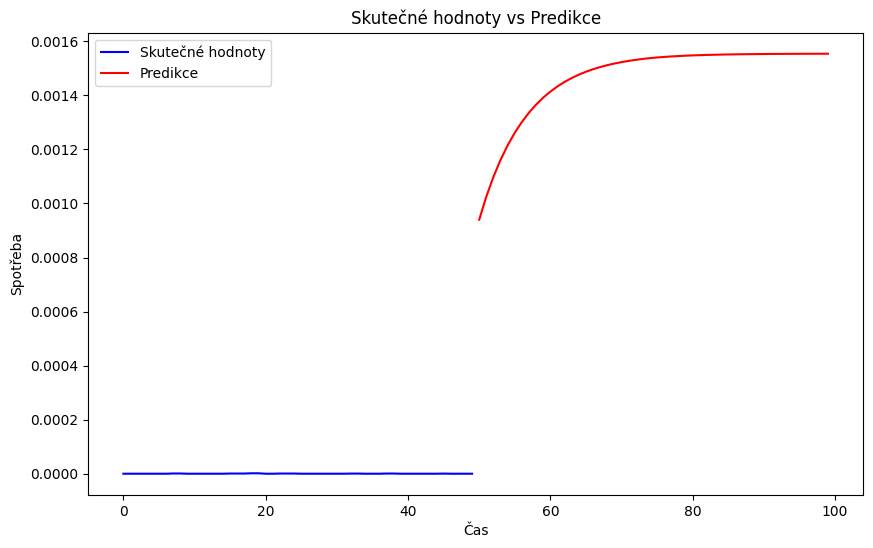

In [39]:
# --- Predikce pro několik kroků dopředu ---
def predict_multiple_steps(model, X, seq_length, n_steps):
    predictions = []
    input_seq = X[-1]  # Začneme s poslední sekvencí

    for _ in range(n_steps):
        pred = model.predict(input_seq.reshape(1, seq_length, 1))
        predictions.append(pred[0][0])
        input_seq = np.append(input_seq[1:], pred)  # Posuneme sekvenci o jedno

    return np.array(predictions)

# --- Kompletní pipeline ---
def lstm_pipeline(filepath, seq_length=24, sample_limit=10000):
    df = load_and_prepare_data(filepath, limit=sample_limit)

    scaler = MinMaxScaler()
    values_scaled = scaler.fit_transform(df[['anonymized_value']].values)

    X, y = create_sequences(values_scaled, seq_length)
    X = X.reshape((X.shape[0], X.shape[1], 1))

    model = build_and_train_lstm(X, y, seq_length)

    last_seq = values_scaled[-seq_length:]
    next_value_scaled = model.predict(last_seq.reshape(1, seq_length, 1))
    next_value_real = scaler.inverse_transform(next_value_scaled)

    print(f"🔮 Predikovaná další hodnota spotřeby: {next_value_real[0][0]:.2f}")

    # --- Graf pro několik kroků dopředu ---
    n_steps = 50  # Počet kroků dopředu
    predictions = predict_multiple_steps(model, X, seq_length, n_steps)

    # --- Skutečné hodnoty vs predikce ---
    plt.figure(figsize=(10,6))
    plt.plot(range(len(values_scaled[-n_steps:])), values_scaled[-n_steps:], label="Skutečné hodnoty", color='blue')
    plt.plot(range(len(values_scaled[-n_steps:]), len(values_scaled[-n_steps:])+n_steps), predictions, label="Predikce", color='red')
    plt.title('Skutečné hodnoty vs Predikce')
    plt.xlabel('Čas')
    plt.ylabel('Spotřeba')
    plt.legend()
    plt.show()

# --- Spuštění ---
lstm_pipeline("C:\\Users\\ondra\\OneDrive\\Plocha\\DataOdectyDecin20241011.csv")